In [48]:
import pandas as pd
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from notebook import utils
import  matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates
%matplotlib inline

# Step 1: Attribute Selection  
## Import Data  

In [6]:
adclicks_df = pd.read_csv("ad-clicks.csv")

In [7]:
adclicks_df = adclicks_df.rename(columns = lambda x:x.strip())

In [9]:
adclicks_df.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing


In [10]:
adclicks_df["adCount"] = 1
adclicks_df.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCount
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies,1
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers,1
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion,1
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing,1


In [12]:
gameclicks_df = pd.read_csv("game-clicks.csv")
gameclicks_df = gameclicks_df.rename(columns = lambda x : x.strip())

In [14]:
gameclicks_df.head(5)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel
0,2016-05-26 15:06:55,105,1038,5916,0,25,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1


In [15]:
gameclicks_df['clickCount'] = 1
gameclicks_df.head(5)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel,clickCount
0,2016-05-26 15:06:55,105,1038,5916,0,25,1,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1,1


In [17]:
buyclicks_df = pd.read_csv("buy-clicks.csv")
buyclicks_df = buyclicks_df.rename(columns = lambda x : x.strip())

In [18]:
buyclicks_df.head(5)

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


### Feature Selection

In [20]:
user_purchases = buyclicks_df[["userId","price"]]
user_purchases.head(5)

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


In [22]:
user_adclicks = adclicks_df[["userId","adCount"]]
user_adclicks.head(5)

,userId,adCount
0,611,1
1,1874,1
2,2139,1
3,212,1
4,1027,1


In [23]:
user_gameclicks = gameclicks_df[["userId","clickCount"]]
user_gameclicks.head(5)

,userId,clickCount
0,1038,1
1,1099,1
2,899,1
3,2197,1
4,1362,1


## Step 2: Training Data

In [24]:
ads_per_user = user_adclicks.groupby("userId").sum()
ads_per_user = ads_per_user.reset_index()
ads_per_user.columns = ["userId","totalAdClicks"]

In [26]:
ads_per_user.head(5)

,userId,totalAdClicks
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


In [28]:
game_clicks_per_user = user_gameclicks.groupby("userId").sum()
game_clicks_per_user = game_clicks_per_user.reset_index()
game_clicks_per_user.columns = ["userId","totalGameClicks"]
game_clicks_per_user.head(5)

,userId,totalGameClicks
0,0,1355
1,1,716
2,2,231
3,6,151
4,8,380


In [29]:
revenue_per_user = user_purchases.groupby("userId").sum()
revenue_per_user = revenue_per_user.reset_index()
revenue_per_user.columns = ["userId","revenue"]
revenue_per_user.head(5)

,userId,revenue
0,1,21.0
1,8,53.0
2,9,80.0
3,10,11.0
4,12,215.0


In [31]:
combined_df = ads_per_user.merge(game_clicks_per_user, on = "userId")
combined_df = combined_df.merge(revenue_per_user,on = "userId")
combined_df.head(5)

,userId,totalAdClicks,totalGameClicks,revenue
0,1,44,716,21.0
1,8,10,380,53.0
2,9,37,508,80.0
3,10,19,3107,11.0
4,12,46,704,215.0


In [35]:
cluster_df = combined_df[["totalAdClicks","totalGameClicks","revenue"]]
cluster_df.head(5)

,totalAdClicks,totalGameClicks,revenue
0,44,716,21.0
1,10,380,53.0
2,37,508,80.0
3,19,3107,11.0
4,46,704,215.0


In [36]:
cluster_df.shape

(543, 3)

In [37]:
sqlc = SQLContext(sc)
p_df = sqlc.createDataFrame(cluster_df)
parsed_data = p_df.rdd.map(lambda line : array([line[0],line[1],line[2]]))

## Step 3: Training to create clusters

In [67]:
km_model = KMeans.train(parsed_data,3,maxIterations = 10,runs = 10,initializationMode = "random")

/usr/lib/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


In [68]:
print(km_model.centers)

[array([  36.44134078,  926.11731844,   46.96648045]), array([   32.35555556,  2310.64444444,    39.42222222]), array([  24.98746082,  357.95924765,   35.06583072])]


In [69]:
centers= km_model.centers
centers[1]


array([   32.35555556,  2310.64444444,    39.42222222])

## Step 4: Recommended Actions

In [70]:
data = {"totalAdClicks":[centers[0][0],centers[1][0],centers[2][0]],"totalGameClicks":[centers[0][1],centers[1][1],centers[2][1]],"revenue":[centers[0][2],centers[1][2],centers[2][2]],"cluster":[1,2,3]}
df = pd.DataFrame(data)
df

,cluster,revenue,totalAdClicks,totalGameClicks
0,1,46.966480,36.441341,926.117318
1,2,39.422222,32.355556,2310.644444
2,3,35.065831,24.987461,357.959248


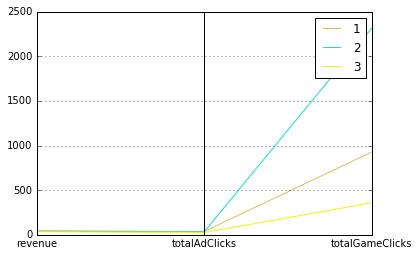

In [71]:
parallel_coordinates(df,"cluster")
plt.show()